In [2]:
import rasterio
import numpy as np
import pandas as pd
from pyproj import Transformer

# Input raster file
input_raster = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/basement/elevation_aoi.tif"
output_csv = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/basement/elevation_aoi.csv"

# Open the raster file
with rasterio.open(input_raster) as src:
    transform = src.transform  # Affine transformation
    data = src.read(1)  # Read raster data
    nodata_value = src.nodata  # NoData value
    crs_utm = src.crs  # Get the CRS (should be UTM)
    
    # Transformer to convert from UTM (EPSG:32614) to WGS 84 (EPSG:4326)
    transformer = Transformer.from_crs(crs_utm, "EPSG:4326", always_xy=True)

    # Get raster dimensions
    height, width = data.shape

    # Create lists to store extracted values
    latitudes, longitudes, elevations = [], [], []

    # Loop over each pixel in the raster
    for row in range(height):
        for col in range(width):
            # Convert pixel coordinates to UTM
            utm_x, utm_y = transform * (col, row)

            # Convert UTM to Latitude/Longitude
            lon, lat = transformer.transform(utm_x, utm_y)

            # Get the elevation value
            elevation = data[row, col]

            # Skip NoData values
            if elevation == nodata_value:
                continue

            # Append to lists
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(elevation)

# Create a DataFrame
df = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes, "Elevation": elevations})

# Save to CSV
df.to_csv(output_csv, index=False)
print(f"CSV file saved: {output_csv}")
print(df.head())  # Print first few rows

CSV file saved: /home/emmanuel/ecastillo/dev/delaware/10102024/data_git/basement/elevation_aoi.csv
    Latitude   Longitude  Elevation
0  31.915139 -104.843472       2393
1  31.915139 -104.843194       2392
2  31.915139 -104.842917       2384
3  31.915139 -104.842639       2375
4  31.915139 -104.842361       2372


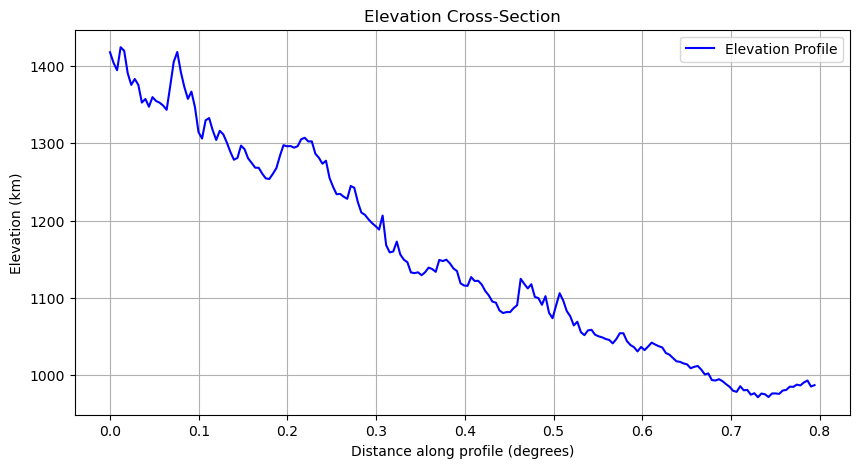

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

# Load the extracted elevation data (from previous step)
df = pd.read_csv("/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/basement/elevation_aoi.csv")  # Update with your actual file path

# Define the two points (Latitude, Longitude)
start_point = (31.75, -104.6691)  # Replace with actual lat/lon
end_point = (31.54, -103.9031)    # Replace with actual lat/lon



# Convert DataFrame columns to numpy arrays
lats = df["Latitude"].values
lons = df["Longitude"].values
elevations = df["Elevation"].values

# Create a 2D KDTree for efficient nearest neighbor search
tree = cKDTree(np.column_stack((lats, lons)))

# Number of points along the profile
num_points = 200  # Increase for higher resolution

# Generate evenly spaced points between the start and end locations
lat_profile = np.linspace(start_point[0], end_point[0], num_points)
lon_profile = np.linspace(start_point[1], end_point[1], num_points)

# Interpolate elevation values at profile points
interpolated_elevations = griddata((lats, lons), elevations, (lat_profile, lon_profile), method="linear")

# Compute distance along the profile (in degrees, for simplicity)
distances = np.linspace(0, np.sqrt((start_point[0] - end_point[0])**2 + (start_point[1] - end_point[1])**2), num_points)

# Plot the elevation profile
plt.figure(figsize=(10, 5))
plt.plot(distances, interpolated_elevations, label="Elevation Profile", color="b")
plt.xlabel("Distance along profile (degrees)")  # Can be converted to km using geopy
plt.ylabel("Elevation (km)")
plt.title("Elevation Cross-Section")
plt.grid()
plt.legend()
plt.show()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Load the extracted elevation data
df = pd.read_csv("/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/basement/elevation_aoi.csv")  # Update with actual file path

# Define the start and end points (Latitude, Longitude)
start_lat, start_lon = 31.7, -104.8  # Replace with actual lat/lon
end_lat, end_lon = 31.7, -103.8      # Replace with actual lat/lon
width_deg = 0.2

df = df[(df["Latitude"] >= start_lat-width_deg) & (df["Latitude"] <= end_lat+width_deg)]
df = df[(df["Longitude"] >= start_lon-width_deg) & (df["Longitude"] <= end_lon+width_deg)]

# Extract lat, lon, and elevation values from DataFrame
lats = df["Latitude"].values
lons = df["Longitude"].values
elevations = df["Elevation"].values

# Generate evenly spaced longitudes between start and end
num_points = 500  # Increase for higher resolution
lon_profile = np.linspace(start_lon, end_lon, num_points)

# Interpolate latitude and elevation for these longitudes
lat_profile = np.interp(lon_profile, lons, lats)  # Interpolating latitudes
elev_profile = griddata((lons, lats), elevations, (lon_profile, lat_profile), method="linear")

cross_plot_data = pd.DataFrame({"Longitude": lon_profile, "Latitude": lat_profile, "Elevation": elev_profile})
cross_plot_data.to_csv(f"cross_elevation_plot_data_{start_lat}_{start_lon}_{end_lat}_{end_lon}.csv", index=False)

# Plot elevation vs. longitude
plt.figure(figsize=(10, 5))
plt.plot(lon_profile, elev_profile, label="Elevation Profile", color="b")
#plt.gca().invert_yaxis()  # Invert y-axis so higher elevations are at the top
plt.xlabel("Longitude")
plt.ylabel("Elevation (m)")
plt.title("Elevation Cross-Section (vs. Longitude)")
plt.grid()
plt.legend()
plt.show()
